In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

import jax.numpy as jnp
import jax.random as jrandom

from plnn.models.algebraic_pl import AlgebraicPL
from plnn.pl import plot_phi


In [2]:
seed = 1231412
rng = np.random.default_rng(seed=seed)

In [3]:
OUTDIR = "out"

In [4]:
SAVE_ANIMATION = True
DT0 = 0.01
SIGMA = 0.4

In [5]:
model, hyperparams = AlgebraicPL.make_model(
    key=jrandom.PRNGKey(0),
    dtype=jnp.float64,
    algebraic_phi_id="phi1",
    tilt_weights=[[-1, 0],[0, 1]],
    tilt_bias=[0, 0],
    sigma=SIGMA,
    signal_type="sigmoid",
    nsigparams=4,
    dt0=DT0,
)

In [6]:
key = jrandom.PRNGKey(rng.integers(2**32))

ncells = 100
x0_val = (0.0, -0.5)
tfin = 20
burnin = 0.2
burnin_signal = (0, 1)
dtsave1 = 0.25
dtsave2 = 2.


# Define signal profile
if model.signal_type == 'jump':
    sigparams = [[5, 0, 1], [7, 0, 1]]
elif model.signal_type == 'sigmoid':
    sigparams = [[10, -1, 1, 0.5], [10, 3, -1, 0.25]]
else:
    raise RuntimeError()
sigparams = jnp.array(sigparams)

# Initial condition
key, subkey = jrandom.split(key, 2)
x0 = np.zeros([ncells, 2])
x0[:] = x0_val

# Simulate particles in the landscape
key, subkey = jrandom.split(key, 2)
ts_all, xs_all, sigs_all, ps_all = model.run_landscape_simulation(
    x0, tfin, [dtsave1, dtsave2], sigparams, subkey, 
    burnin=burnin
)

ts, ts_saved = ts_all
xs, xs_saved = xs_all
sigs, sigs_saved = sigs_all
ps, ps_saved = ps_all

In [7]:
from plnn.vectorfields import find_minima_along_tilt_trajectory
from plnn.vectorfields import check_minima_trajectories_for_bifurcations

minima = find_minima_along_tilt_trajectory(
    model, ps,
    ndivisions=20,
    n=10,
    tol=1e-1,
    x0_range=[[-4,4],[-4,4]],
    method="BFGS",
    opt_tol=1e-5,
)

bifs, bif_idxs, bif_tilts, bif_mins = check_minima_trajectories_for_bifurcations(
    ps, minima
)

Identified 3 potential bifurcation points...
At time t=5.25:
	tau=(0.983, 2.66)
	mins0:
		[-0.12874662 -0.94595563]
	mins1:
		[-0.1289055  -0.94008575]
		[-1.12140309  0.51975439]
At time t=9.0:
	tau=(0.462, 1.49)
	mins0:
		[-0.07755064 -0.74185537]
		[-1.26178248  0.75026736]
	mins1:
		[-0.06255667 -0.7141107 ]
		[-1.25925573  0.7572901 ]
		[1.0052708  0.54984428]
At time t=10.75:
	tau=(-0.358, 0.629)
	mins0:
		[ 0.10937038 -0.40359603]
		[-1.22401159  0.78569879]
		[1.33997295 0.86433428]
	mins1:
		[1.36327789 0.88689143]
		[-1.21956575  0.79103505]
Starting points for potential bifurcations:
 [[-0.12874662 -0.94595563]
 [-0.1289055  -0.94008575]
 [-1.12140309  0.51975439]
 [-0.07755064 -0.74185537]
 [-1.26178248  0.75026736]
 [-0.06255667 -0.7141107 ]
 [-1.25925573  0.7572901 ]
 [ 1.0052708   0.54984428]
 [ 0.10937038 -0.40359603]
 [-1.22401159  0.78569879]
 [ 1.33997295  0.86433428]
 [ 1.36327789  0.88689143]
 [-1.21956575  0.79103505]]


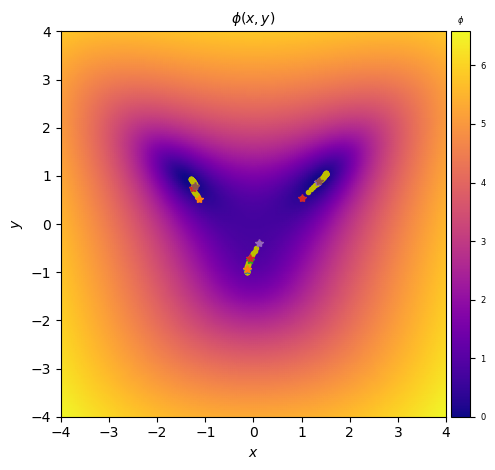

In [8]:
fig, ax = plt.subplots(1, 1)

print(f"Identified {len(bif_idxs)} potential bifurcation points...")
for i in range(len(bif_idxs)):
    tau0, tau1 = bif_tilts[i]
    mins0, mins1 = bif_mins[i]
    print(f"At time t={ts[bif_idxs[i]]}:")
    print(f"\ttau=({', '.join([f'{x:.3g}' for x in tau0])})")
    print(f"\tmins0:")
    for m in mins0:
        print(f"\t\t{m}")
    print(f"\tmins1:")
    for m in mins1:
        print(f"\t\t{m}")

plot_phi(
    model,
    tilt=[0,0],
    res=200,
    equal_axes=True,
    ax=ax,
    show=True,
)

for i in range(len(minima)):
    ax.plot(minima[i][:,0], minima[i][:,1], '.y');

for minset in bif_mins:
    for min in minset:
        ax.plot(min[:,0], min[:,1], '*');

print(f"Starting points for potential bifurcations:\n", bifs)

In [9]:
from cont.binary_choice import get_binary_choice_curves

bifseed1 = rng.integers(2**32)
bifseed2 = rng.integers(2**32)

landscape_tex = "$\phi$"

# bifcurves, bifcolors = get_plnn_bifurcation_curves(
#     model, 
#     xstarts=[[x, 'r'] for x in bifs],
#     xlims=[-2,2], ylims=[-2,2],
#     num_starts=50,
#     p1lims=[-2,2], p2lims=[-0.75,3],
#     seed=bifseed1,
#     color='r',
#     verbosity=0,
# )

bifcurves, bifcolors = get_binary_choice_curves(seed=0)


# Filter out singleton bifurcation curves and remove initial estimate point
keepidxs = [i for i in range(len(bifcurves)) if len(bifcurves[i]) > 1]
bifcurves = [bc[1:] for bc in bifcurves if len(bc) > 1]
bifcolors = [bifcolors[i] for i in keepidxs]


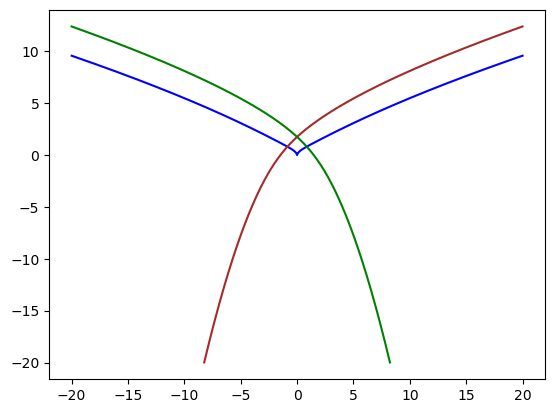

In [10]:
fig, ax = plt.subplots(1, 1)

for i in range(len(bifcurves)):
    curve = bifcurves[i]
    color = bifcolors[i]
    ax.plot(curve[:,0], curve[:,1], color=color, linestyle='-')

In [11]:
from plnn.data_generation.plnn_animator import PLNNSimulationAnimator

duration = 10
dpi = 200
grid_size = 1

animator = PLNNSimulationAnimator(
    model, sigparams,
    ts, xs, sigs, ps, 
    ts_saved, xs_saved, sigs_saved, ps_saved, 
    xlims=[-4, 4], ylims=[-4, 4],
    p0lims=[-2, 2],
    p1lims=[-1, 3],
    minima=minima,
    bifcurves=bifcurves,
    bifcolors=bifcolors,
    view_init=(45, 30),
)

ani = animator.animate(
    duration=duration,
    dpi=dpi,
    grid_width=grid_size,
    grid_height=grid_size,
)
plt.close()

Generating movie...
Finished in 1.03 seconds.


In [12]:
HTML(ani.to_html5_video())

Generating movie...
Finished in 0.8 seconds.
Saving animation to out/phi1_ani_demo


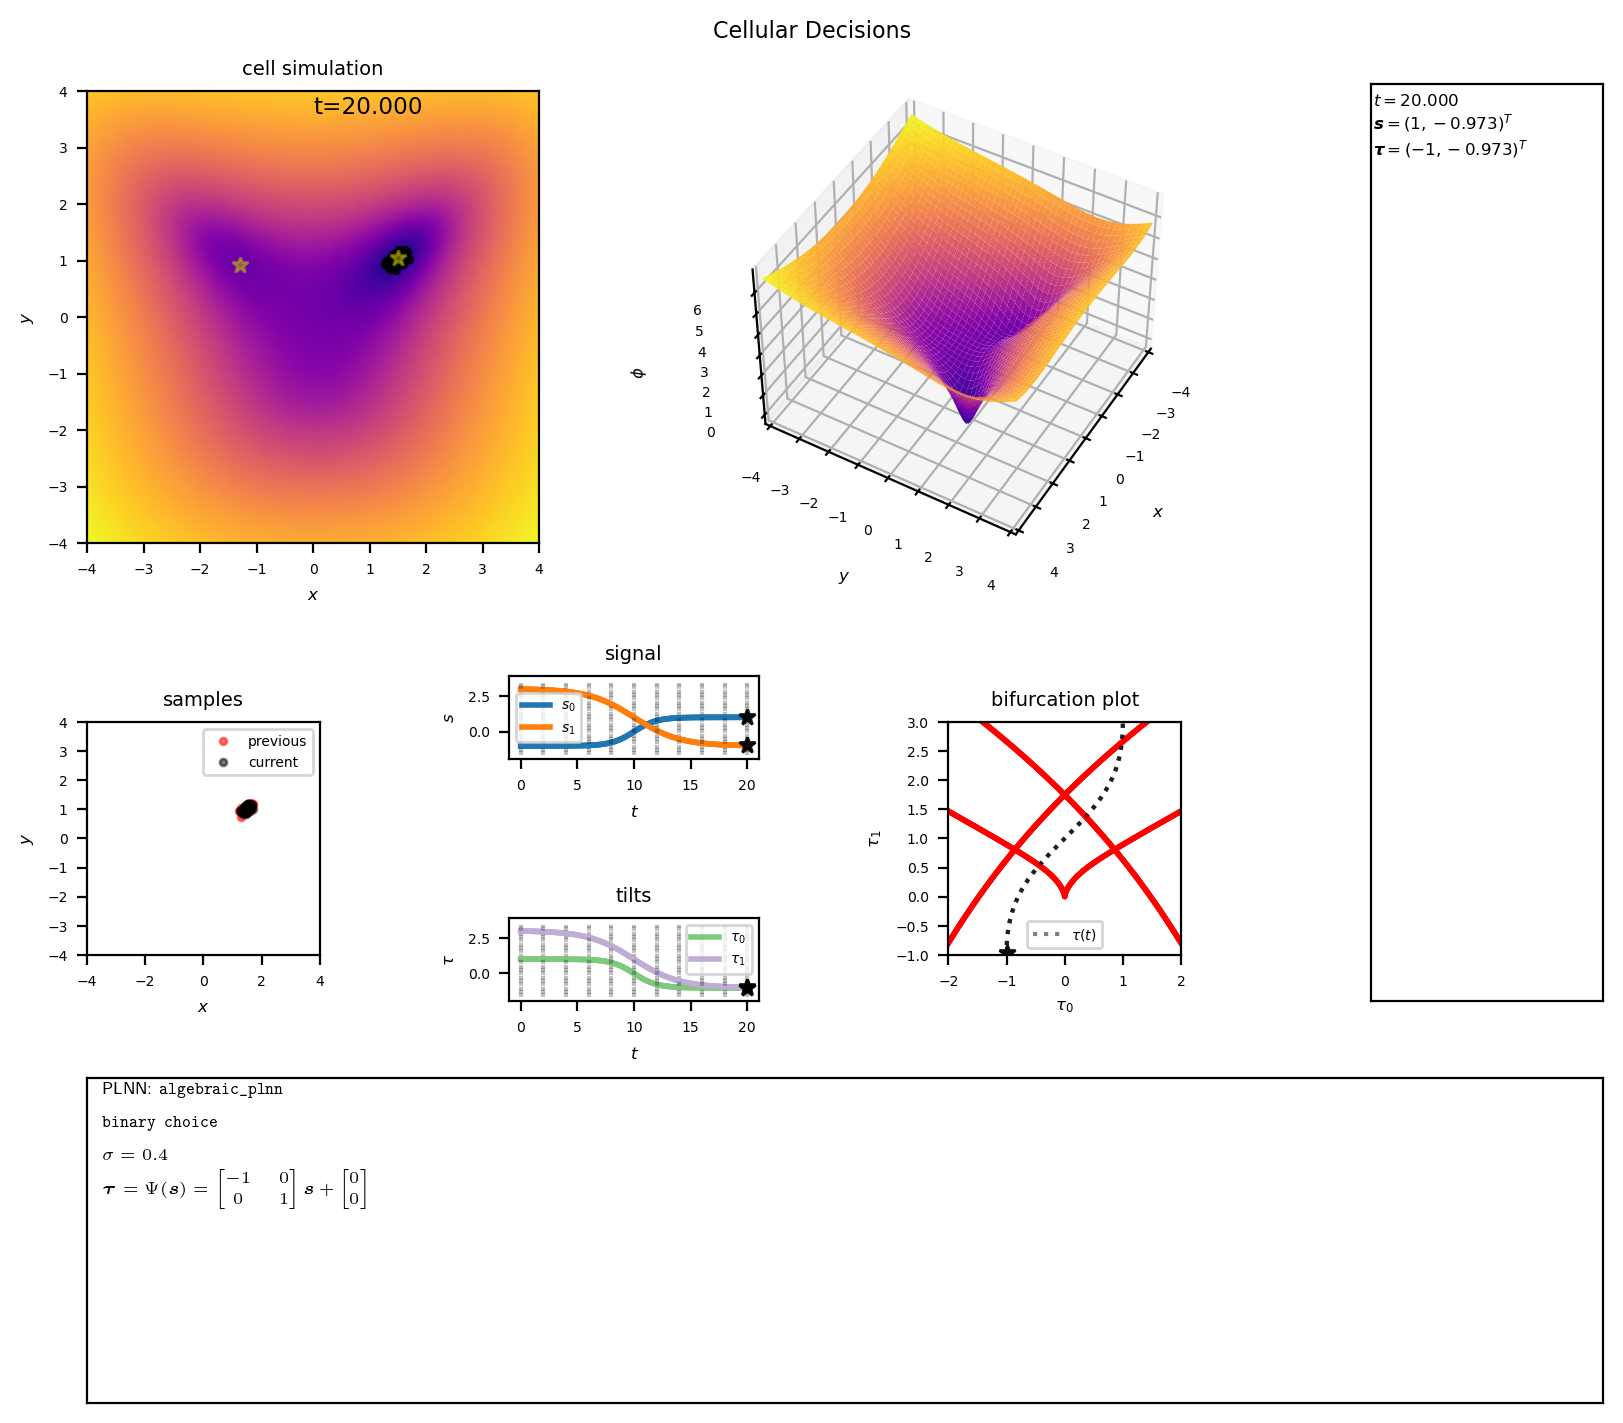

In [13]:
if SAVE_ANIMATION:
    ani = animator.animate(
        savepath=f"{OUTDIR}/phi1_ani_demo",
        saveas='mp4',
        duration=duration,
        dpi=dpi,
        grid_width=grid_size,
        grid_height=grid_size,
    )

Generating movie...
Finished in 0.767 seconds.
Saving animation to out/phi1_ani_demo


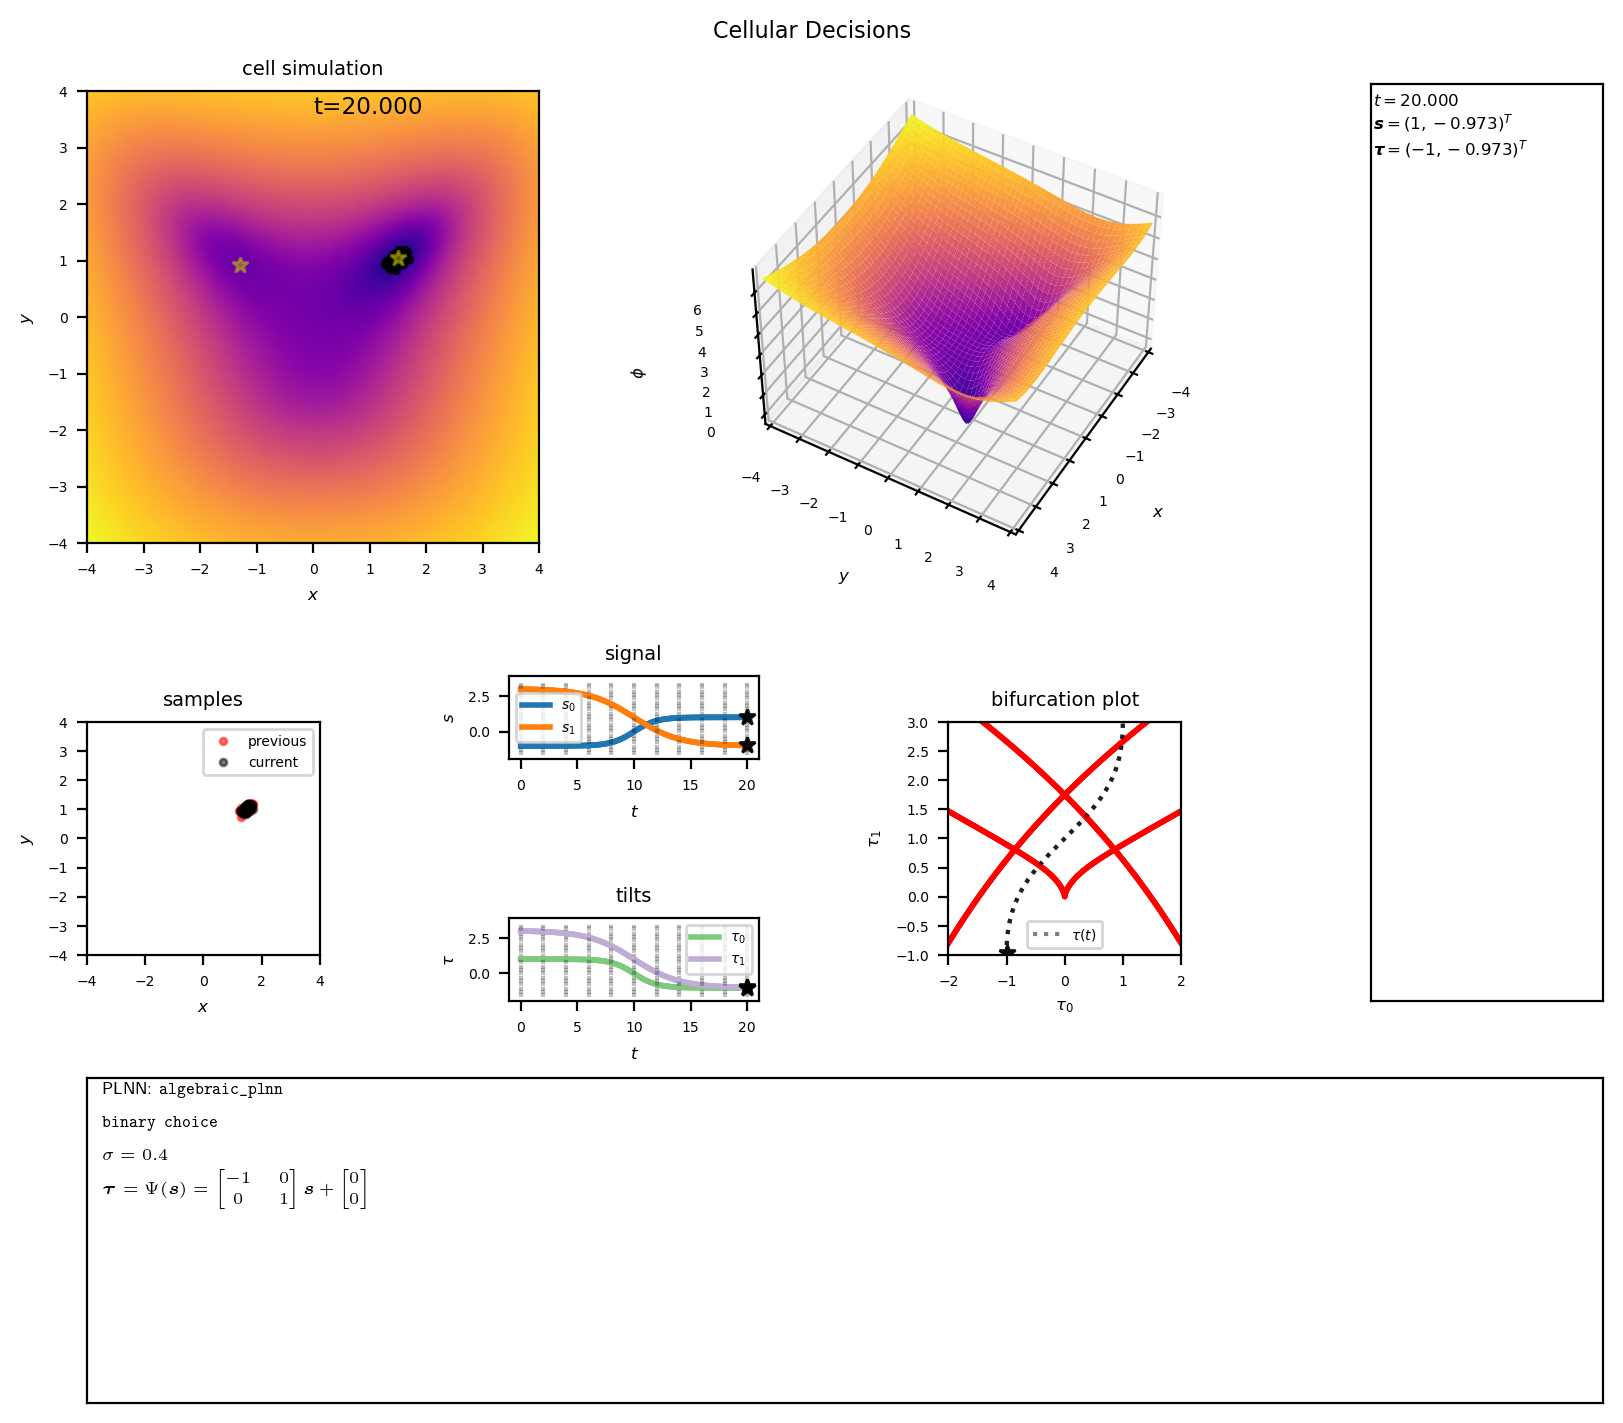

In [14]:
if SAVE_ANIMATION:
    ani = animator.animate(
        savepath=f"{OUTDIR}/phi1_ani_demo",
        saveas='gif',
        duration=duration,
        dpi=dpi,
        grid_width=grid_size,
        grid_height=grid_size,
    )